In [41]:
import sys
!{sys.executable} -m pip install pydicom

!{sys.executable} -m pip install pillow

!{sys.executable} -m pip install scikit-image

!{sys.executable} -m pip install SimpleITK



Label(value='CT')

FloatSlider(value=60.0, description='angle interval', max=180.0)

IntSlider(value=80, description='det. number', max=720)

FloatSlider(value=100.0, description='ang. extent', max=270.0)

Text(value='ct_scan.png', description='Input file')

Feel free to write a .dcm filename


Checkbox(value=False, description='denoise')

Checkbox(value=False, description='step by step')

Text(value='Michał Cichy', description='Name')

Text(value='123456', description='Id')

Text(value='M', description='Sex (F/M)')

Text(value='', description='comment')

Button(description='Run parallel', style=ButtonStyle())

Button(description='Run conical', style=ButtonStyle())

ct_scan.png


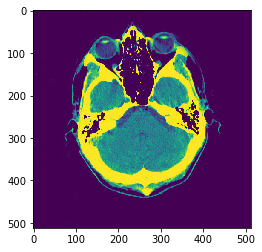

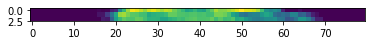

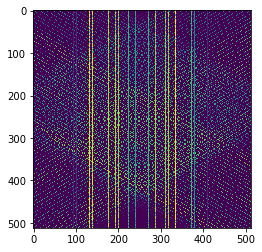

RMSE=186.93139434606005


In [4]:
from abc import abstractmethod

from bresenham import bresenham
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipykernel.pylab.backend_inline import flush_figures
from skimage import filters, io
from skimage.restoration import denoise_nl_means, estimate_sigma
from IPython.display import display
import math
from datetime import date

import os
import tempfile
import datetime

import pydicom
from pydicom.dataset import Dataset, FileDataset

import SimpleITK as sitk


def RMSE(matrix1, matrix2):
    sum = 0

    for y in range(matrix1.shape[0]):
        for x in range(matrix1.shape[1]):
            sum += (matrix1[y][x] - matrix2[y][x]) ** 2

    return sum ** 0.5


def denoise(img):
    estimatedSigma = np.mean(estimate_sigma(img, multichannel=True))
    return denoise_nl_means(img, h=0.8 * estimatedSigma, fast_mode=True)
#     return filters.gaussian(img, sigma=0.35)

#https://pyscience.wordpress.com/2014/09/08/dicom-in-python-importing-medical-image-data-into-numpy-with-pydicom-and-vtk/
def loadDicom(fileName):
    RefDs = pydicom.dcmread(fileName)

    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns))
    ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
    ArrayDicom[:, :] = RefDs.pixel_array

    return ArrayDicom


# ------------------------- CT "abstract" class
class CT:

    def __init__(self, filepath, withAnimation, denoise=False, unique_name=""):
        self.imgToProcess = self.readProcessedImage(filepath)
        self.showImgToProcess()
        self.sinogram = None
        self.resultImage = None
        self.mapOfTransitions = None
        self.circleCoords = self.computeCircleEquation()
        self.withAnimation = withAnimation
        self.resultStepByStep = None
        self.mapOfTransitionsStepByStep = None
        self.RMSEwidget = None
        self.denoise = denoise
        self.unique_name = unique_name

    @abstractmethod
    def transformSinogramToResultImage(self, angleInterval, angularExtent):
        pass

    def doCT(self, angleInterval, angularExtent, detectorsNumber):
        self.createSinogram(angleInterval, angularExtent, detectorsNumber)
        self.drawSinogram()
        self.transformSinogramToResultImage(angleInterval, angularExtent)
        self.divideByTransitionNumber()
        if self.denoise == True:
            print("Denoise is on")
            self.resultImage = denoise(self.resultImage)
        self.drawResultImage()

    def addLineToResult(self, hPos, dPos, value):
        transitionPoints = list(bresenham(hPos[0], hPos[1], dPos[0], dPos[1]))
        for point in transitionPoints:
            if 0 <= point[0] < self.imgToProcess.shape[0] and 0 <= point[1] < self.imgToProcess.shape[1]:
                self.mapOfTransitions[point[0]][point[1]] += 1
                self.resultImage[point[0]][point[1]] += value

    def divideByTransitionNumber(self):
        for i in range(self.resultImage.shape[0]):
            for j in range(self.resultImage.shape[1]):
                if self.mapOfTransitions[i][j] != 0:
                    self.resultImage[i][j] /= self.mapOfTransitions[i][j]
                else:
                    self.resultImage[i][j] = 0

    def computeDetectedValue(self, hPos, dPos):
        transitionPoints = list(bresenham(hPos[0], hPos[1], dPos[0], dPos[1]))
        sumOfBrightness = 0
        numberOfIncludedPixels = 0
        for point in transitionPoints:
            if 0 < point[0] < self.imgToProcess.shape[0] and 0 < point[1] < self.imgToProcess.shape[1]:
                numberOfIncludedPixels += 1
                sumOfBrightness += self.imgToProcess[point[0]][point[1]]
        if numberOfIncludedPixels > 0:
            return sumOfBrightness / numberOfIncludedPixels
        return 0

    def readProcessedImage(self, filepath):
        print(filepath)
        if filepath[-4:] == '.dcm':
            print("DICOM FILE SELECTED")
            return loadDicom(filepath)
        else:
            return mpimg.imread(filepath)

    def drawResultImage(self):
        plt.imshow(self.resultImage)
        plt.show()
        print("RMSE="+str(RMSE(self.resultImage, self.imgToProcess)))
                          
    def drawSinogram(self):
        plt.imshow(self.sinogram)
        plt.show()

    def showImgToProcess(self):
        plt.imshow(self.imgToProcess)
        plt.show()

    def computeCircleEquation(self):
        coords = list(map(lambda x: x / 2, self.imgToProcess.shape))
        radius = (coords[0] ** 2 + coords[1] ** 2) ** 0.5
        return {'x': coords[0], 'y': coords[1], 'r': radius}

    def getDevicePosition(self, alpha):
        x = self.circleCoords['x'] + self.circleCoords['r'] * np.cos(alpha)
        y = self.circleCoords['y'] + self.circleCoords['r'] * np.sin(alpha)
        return [int(x), int(y)]

    @abstractmethod
    def createSinogram(self, angleInterval, angularExtent, detectorsNumber):
        pass

    def on_change(self, x=0):
        io.imshow(self.resultStepByStep[x])
        flush_figures()
        rmse = RMSE(self.imgToProcess, self.resultStepByStep[x])
        self.RMSEwidget = widgets.Label(value=str(rmse))
        display(self.RMSEwidget)

    def normalizeStep(self, step):
        for x in range(len(self.mapOfTransitionsStepByStep[step])):
            for y in range(len(self.mapOfTransitionsStepByStep[step][x])):
                if self.mapOfTransitionsStepByStep[step][x][y] != 0:
                    self.resultStepByStep[step][x][y] /= self.mapOfTransitionsStepByStep[step][x][y]

    def getResultImage(self):
        return self.resultImage

    def getInitialImage(self):
        return self.imgToProcess

# ------------------------- Conical CT class
class ConicalCT(CT):
    def __init__(self, filepath, withAnimation=False, denoise=False, unique_name=""):
        super().__init__(filepath, withAnimation, denoise, unique_name)

    def transformSinogramToResultImage(self, angleInterval, angularExtent):
        self.resultImage = np.zeros(self.imgToProcess.shape)
        self.mapOfTransitions = np.zeros(self.imgToProcess.shape)
        if self.withAnimation:
            self.resultStepByStep = [np.zeros(self.imgToProcess.shape)]
            self.mapOfTransitionsStepByStep = [np.zeros(self.imgToProcess.shape)]
        for i in range(self.sinogram.shape[0]):
            headerPosition = self.getDevicePosition(angleInterval * i)
            for j in range(self.sinogram.shape[1]):
                detectorPosition = self.getDevicePosition(
                    angleInterval * i + np.pi - angularExtent / 2 + j * angularExtent / self.sinogram.shape[1])
                self.addLineToResult(headerPosition, detectorPosition, self.sinogram[i][j])
            if self.withAnimation:
                self.resultStepByStep.append(self.resultImage.copy())
                self.normalizeStep(i)
                self.mapOfTransitionsStepByStep.append(self.mapOfTransitions.copy())
        if self.withAnimation:
            widgets.interact(self.on_change, x=(0, len(self.resultStepByStep) - 1, 1))

    def createSinogram(self, angleInterval, angularExtent, detectorsNumber):
        self.sinogram = np.zeros((int(2 * np.pi / angleInterval), detectorsNumber))
        for headerAngle, i in zip(np.arange(0, 2 * np.pi, angleInterval), range(int(2 * np.pi / angleInterval))):
            headerPosition = self.getDevicePosition(headerAngle)
            for detectorAngle, j in zip(np.arange(headerAngle + np.pi - angularExtent / 2,
                                                  headerAngle + np.pi + angularExtent / 2,
                                                  angularExtent / detectorsNumber), range(detectorsNumber)):
                detectorPosition = self.getDevicePosition(detectorAngle)
                self.sinogram[i][j] = self.computeDetectedValue(headerPosition, detectorPosition)


# ------------------------- Parallel CT class
class ParallelCT(CT):
    def __init__(self, filepath, withAnimation=False, denoise=False, unique_name=""):
        super().__init__(filepath, withAnimation, denoise, unique_name)

    def transformSinogramToResultImage(self, angleInterval, angularExtent):
        self.resultImage = np.zeros(self.imgToProcess.shape)
        self.mapOfTransitions = np.zeros(self.imgToProcess.shape)
        if self.withAnimation:
            self.resultStepByStep = [np.zeros(self.imgToProcess.shape)]
            self.mapOfTransitionsStepByStep = [np.zeros(self.imgToProcess.shape)]
        for i in range(self.sinogram.shape[0]):
            for j in range(self.sinogram.shape[1]):
                emitterPosition = self.getDevicePosition(
                    angleInterval * i - angularExtent / 2 + j * angularExtent / self.sinogram.shape[1])
                detectorPosition = self.getDevicePosition(
                    angleInterval * i + np.pi + angularExtent / 2 - j * angularExtent / self.sinogram.shape[1])
                self.addLineToResult(emitterPosition, detectorPosition, self.sinogram[i][j])
            if self.withAnimation:
                self.resultStepByStep.append(self.resultImage.copy())

                self.normalizeStep(i)
                self.mapOfTransitionsStepByStep.append(self.mapOfTransitions.copy())
        if self.withAnimation:
            widgets.interact(self.on_change, x=(0, len(self.resultStepByStep) - 1, 1))

    def createSinogram(self, angleInterval, angularExtent, detectorsNumber):
        self.sinogram = np.zeros((int(np.pi / angleInterval), detectorsNumber))
        for centralPoint, i in zip(np.arange(0, np.pi, angleInterval), range(int(np.pi / angleInterval))):
            for j in range(detectorsNumber):
                emitterAngle = self.getDevicePosition(
                    centralPoint - angularExtent / 2 + j * angularExtent / detectorsNumber)
                detectorPosition = self.getDevicePosition(
                    centralPoint + np.pi + angularExtent / 2 - j * angularExtent / detectorsNumber)
                self.sinogram[i][j] = self.computeDetectedValue(emitterAngle, detectorPosition)


# to receive pretty good image for ConicalCT you have to use angular extend close to 180 degree
# p = ParallelCT('ct_scan.png', withAnimation=True)
# p.doCT(np.pi / 30, np.pi/2.3, 100)
# p = ConicalCT('ct_scan.png' , withAnimation=True)
# p.doCT(np.pi / 30, np.pi/1.2, 100)

titleWidget = widgets.Label(value="CT")
angleIntervalWidget = widgets.FloatSlider(description="angle interval", min=0, max=180, value=60)
detectorsNumberWidget = widgets.IntSlider(description="det. number", min=0, max=720, value=80)
angularExtentWidget = widgets.FloatSlider(description="ang. extent", min=0, max=270, value=100)

runParallelWidget = widgets.Button(description="Run parallel")
runConicalWidget = widgets.Button(description="Run conical")

denoiseWidget = widgets.Checkbox(
    value=False,
    description='denoise',
)

stepByStepWidget = widgets.Checkbox(
    value=False,
    description='step by step',
)


nameWidget = widgets.Text(value='Michał Cichy', description="Name")
idWidget = widgets.Text(value='123456', description="Id")
sexWidget = widgets.Text(value="M", description="Sex (F/M)")
commentsWidget = widgets.Text(value="", description="comment")
fileWidget = widgets.Text(value="ct_scan.png", description="Input file")

def runParallel(x):
    angleInterval = angleIntervalWidget.value * math.pi / 180
    detectorsNumber = detectorsNumberWidget.value
    angularExtent = angularExtentWidget.value * math.pi / 180

    p = ParallelCT(fileWidget.value, withAnimation=stepByStepWidget.value, denoise=denoiseWidget.value)
    p.doCT(angleInterval, angularExtent, detectorsNumber)

    saveDicom(p.getResultImage(), 'patient.dcm')


def runConical(x):
    angleInterval = angleIntervalWidget.value * math.pi / 180
    detectorsNumber = detectorsNumberWidget.value
    angularExtent = angularExtentWidget.value * math.pi / 180

    p = ConicalCT(fileWidget.value, withAnimation=stepByStepWidget.value, denoise=denoiseWidget.value)
    p.doCT(angleInterval, angularExtent, detectorsNumber)

    saveDicom(p.getResultImage(), 'patient.dcm')

def saveDicom(image, file):
    filename = pydicom.data.get_testdata_files("MR_small.dcm")[0]

    ds = pydicom.dcmread(filename)
    
    ds.PatientName = nameWidget.value
    ds.PatientId = idWidget.value
    ds.PatientSex = sexWidget.value
    ds.StudyDate = date.today()
    ds.ImageComments = [commentsWidget.value]
    
    image *= 255 / np.max(image)
    ds.PixelData = image.astype(np.uint8).tobytes()
    ds.Rows = image.shape[0]
    ds.Columns = image.shape[1]
    ds.BitsAllocated = 8
    ds.BitsStored = 8
    ds.HighBit = 7
    ds.PixelRepresentation = 0
    ds[(0x7fe0, 0x0010)].is_undefined_length = False
    ds.save_as(file)

runParallelWidget.on_click(runParallel)
runConicalWidget.on_click(runConical)

display(titleWidget)
display(angleIntervalWidget)
display(detectorsNumberWidget)
display(angularExtentWidget)
display(fileWidget)
print("Feel free to write a .dcm filename")
display(denoiseWidget)
display(stepByStepWidget)

display(nameWidget)
display(idWidget)
display(sexWidget)
display(commentsWidget)

display(runParallelWidget)
display(runConicalWidget)

